Neurone 0: Burstiness Index = 0.18390433096315453
Neurone 1: Burstiness Index = 0.18390433096315453
Neurone 2: Burstiness Index = 0.187136393018746
Neurone 3: Burstiness Index = 0.18552036199095026
Neurone 4: Burstiness Index = 0.19521654815772463


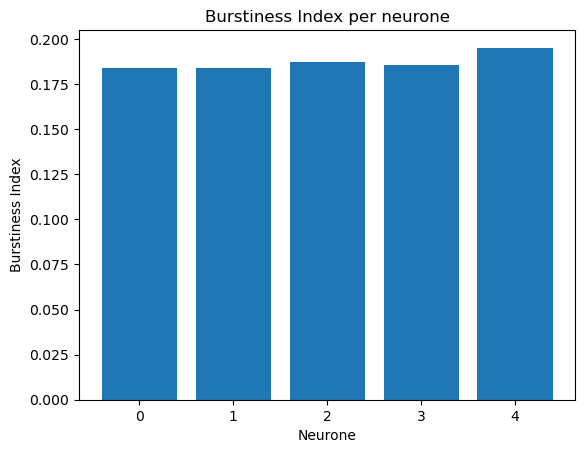

In [1]:
import numpy as np
import h5py
import neo
import matplotlib.pyplot as plt
def BurstinessIndex(timestamps, fs, sim_time_samples=float('NaN')):
    """
    Calculate the Burstiness Index of spike trains over time bins.

    Parameters
    ----------
    timestamps : list of 1D numpy arrays
        Each array contains spike times (in samples) for a neuron.
    fs : float
        Sampling frequency in Hz.
    sim_time_samples : float, optional
        Total simulation time in samples. If not specified, must be manually set.

    Returns
    -------
    BurstinessIndex : float
        A measure of how bursty the population activity is.
        - Values close to 0 indicate uniform spiking.
        - Values close to 1 indicate that spikes are concentrated in a few bins (i.e., bursty activity).
    """

    bin_width = 1000     # in ms (should be 1000 ms if we want to divide the recording in 1s-bins)
    factor = 0.15       # 0.15
    bin_width_samples = bin_width*fs/1000
    nbins = sim_time_samples/bin_width_samples
    nspikes_x_bin = []
    for b in range(int(nbins)):
        idx_inf = b*bin_width_samples
        idx_sup = (b+1)*bin_width_samples
        spikes_count = 0
        for neuron in timestamps:
            sup_lim = np.where(neuron < idx_sup)[0]
            both_lim = np.where(neuron[sup_lim] >= idx_inf)[0]
            spikes_count += len(both_lim)
        nspikes_x_bin.append(spikes_count)

    nspikes_x_bin_sorted = np.array(sorted(nspikes_x_bin, reverse=True))
    f15_bins = nspikes_x_bin_sorted[range(round(factor*nbins))]
    f15 = sum(f15_bins)/sum(nspikes_x_bin_sorted)
    BurtinessIndex = (f15-factor)/(1-factor)

    return BurtinessIndex

filename = '../templates/spiketrains.h5'
duration = 120  # stesso t_stop usato prima
fs = 32000  # Hz

import quantities as pq
import neo

spike_trains = []
with h5py.File(filename, 'r') as f:
    for key in f.keys():
        times = f[key][()]  # array di spike times in secondi
        st = neo.SpikeTrain(times * pq.s, t_start=0 * pq.s, t_stop=duration * pq.s)
        spike_trains.append(st)

Spikes = []
for sp in spike_trains:
    sp_values = sp.rescale('s').magnitude  # solo valori float in secondi
    spikes_samples = (sp_values * fs).astype(int)
    Spikes.append(spikes_samples)

burstiness_values = []

for spike_train in Spikes:
    bi = BurstinessIndex([spike_train], fs, sim_time_samples=duration * fs)
    burstiness_values.append(bi)

# Stampa i valori
for i, bi in enumerate(burstiness_values):
    print(f"Neurone {i}: Burstiness Index = {bi}")



plt.bar(range(len(burstiness_values)), burstiness_values)
plt.xlabel('Neurone')
plt.ylabel('Burstiness Index')
plt.title('Burstiness Index per neurone')
plt.show()

